In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install cython pyyaml==5.1

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
!pip install clearml


In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=74E1MQT3ZZD05XEGU9KGLQCZWEH1I0
%env CLEARML_API_SECRET_KEY=BqXaAM3UWu2XHbEznD2adyrzQlMy1q5vsWgiM4JHVu0e03YUbuFhVoJd7RbbILZATRE

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=74E1MQT3ZZD05XEGU9KGLQCZWEH1I0
env: CLEARML_API_SECRET_KEY=BqXaAM3UWu2XHbEznD2adyrzQlMy1q5vsWgiM4JHVu0e03YUbuFhVoJd7RbbILZATRE


In [2]:
!clearml-init

from clearml import Task

task = Task.init(project_name="DeepFashion", task_name="DeefFashion_mask_rcnn_R_50_FPN_3x")

ClearML SDK setup process

Please create new clearml credentials through the settings page in your `clearml-server` web app (e.g. http://localhost:8080//settings/workspace-configuration) 
Or create a free account at https://app.clear.ml/settings/workspace-configuration

In settings page, press "Create new credentials", then press "Copy to clipboard".

Paste copied configuration here:
^C
Traceback (most recent call last):
  File "/opt/conda/bin/clearml-init", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.10/site-packages/clearml/cli/config/__main__.py", line 82, in main
    api_input = input()
KeyboardInterrupt
ClearML Task: created new task id=59ae278a17c240ffbee4a54a2d2b6ec8
2024-11-15 17:02:26,762 - clearml.Repository Detection - WARNING - Jupyter Notebook auto-logging failed, could not access: /kaggle/working/__notebook_source__.ipynb
2024-11-15 17:02:26,768 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.

/opt/conda/lib/python3.10/site-packages/clearml/utilities/process/mp.py:629: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start
2024-11-15 18:09:49,932 - clearml.storage - INFO - Uploading: 0.02MB to /tmp/tmp7oebu62m.jpeg


/opt/conda/lib/python3.10/site-packages/clearml/utilities/process/mp.py:629: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

                                            0% | 0.00/0.02 MB [00:00<?, ?MB/s]: /opt/conda/lib/python3.10/site-packages/tqdm/std.py:636: TqdmWarning:

clamping frac to range [0, 1]

█████████████████████████████████ 114% | 0.02/0.02 MB [00:00<00:00,  7.34s/MB]: 


In [3]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
import os

setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("deepfashion_train", {}, "/kaggle/input/df2-train-img/ann_train.json", "/kaggle/input/df2-train-img/train_image/image")

In [5]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("deepfashion_train",)
cfg.DATASETS.TEST = ()

cfg.SOLVER.BASE_LR = 0.002  # Start with a slightly higher learning rate
cfg.SOLVER.WARMUP_ITERS = int(0.1 * cfg.SOLVER.MAX_ITER)  # 10% of training as warm-up
cfg.SOLVER.MAX_ITER = 3000  # Adjust based on dataset size
cfg.SOLVER.STEPS = (4000, 6000)
cfg.SOLVER.GAMMA = 0.1      # Less aggressive decay

cfg.SOLVER.IMS_PER_BATCH = 8
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  # Improves sampling quality
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13 

cfg.SOLVER.WEIGHT_DECAY = 0.0001

cfg.SOLVER.CHECKPOINT_PERIOD = 1000  # Save model every 1000 iterations

cfg.TEST.EVAL_PERIOD = 1000
cfg.OUTPUT_DIR = "/kaggle/working"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [6]:
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

[11/15 17:02:51 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [7]:
trainer.train()

[11/15 17:06:07 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

/opt/conda/lib/python3.10/site-packages/torch/functional.py:513: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3609.)



[11/15 17:06:31 d2.utils.events]:  eta: 0:56:19  iter: 19  total_loss: 3.814  loss_cls: 2.792  loss_box_reg: 0.2837  loss_mask: 0.6932  loss_rpn_cls: 0.01601  loss_rpn_loc: 0.01564    time: 1.1305  last_time: 1.1749  data_time: 0.0903  last_data_time: 0.0679   lr: 1.4654e-05  max_mem: 9360M
[11/15 17:06:54 d2.utils.events]:  eta: 0:56:09  iter: 39  total_loss: 3.417  loss_cls: 2.321  loss_box_reg: 0.3215  loss_mask: 0.6923  loss_rpn_cls: 0.01775  loss_rpn_loc: 0.01906    time: 1.1379  last_time: 1.2024  data_time: 0.0482  last_data_time: 0.0506   lr: 2.7974e-05  max_mem: 9361M
[11/15 17:07:17 d2.utils.events]:  eta: 0:56:09  iter: 59  total_loss: 2.582  loss_cls: 1.52  loss_box_reg: 0.3142  loss_mask: 0.6896  loss_rpn_cls: 0.01691  loss_rpn_loc: 0.01565    time: 1.1425  last_time: 1.2695  data_time: 0.0531  last_data_time: 0.0724   lr: 4.1294e-05  max_mem: 9361M
[11/15 17:07:40 d2.utils.events]:  eta: 0:55:23  iter: 79  total_loss: 1.757  loss_cls: 0.7232  loss_box_reg: 0.3256  loss_ma

In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55
cfg.DATASETS.TEST = ("deepfashion_train", )
predictor = DefaultPredictor(cfg)

[11/15 18:09:14 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/model_final.pth ...


/opt/conda/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:277: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



2024-11-15 18:09:15,276 - clearml.model - WARNING - Connecting multiple input models with the same name: `model_final`. This might result in the wrong model being used when executing remotely


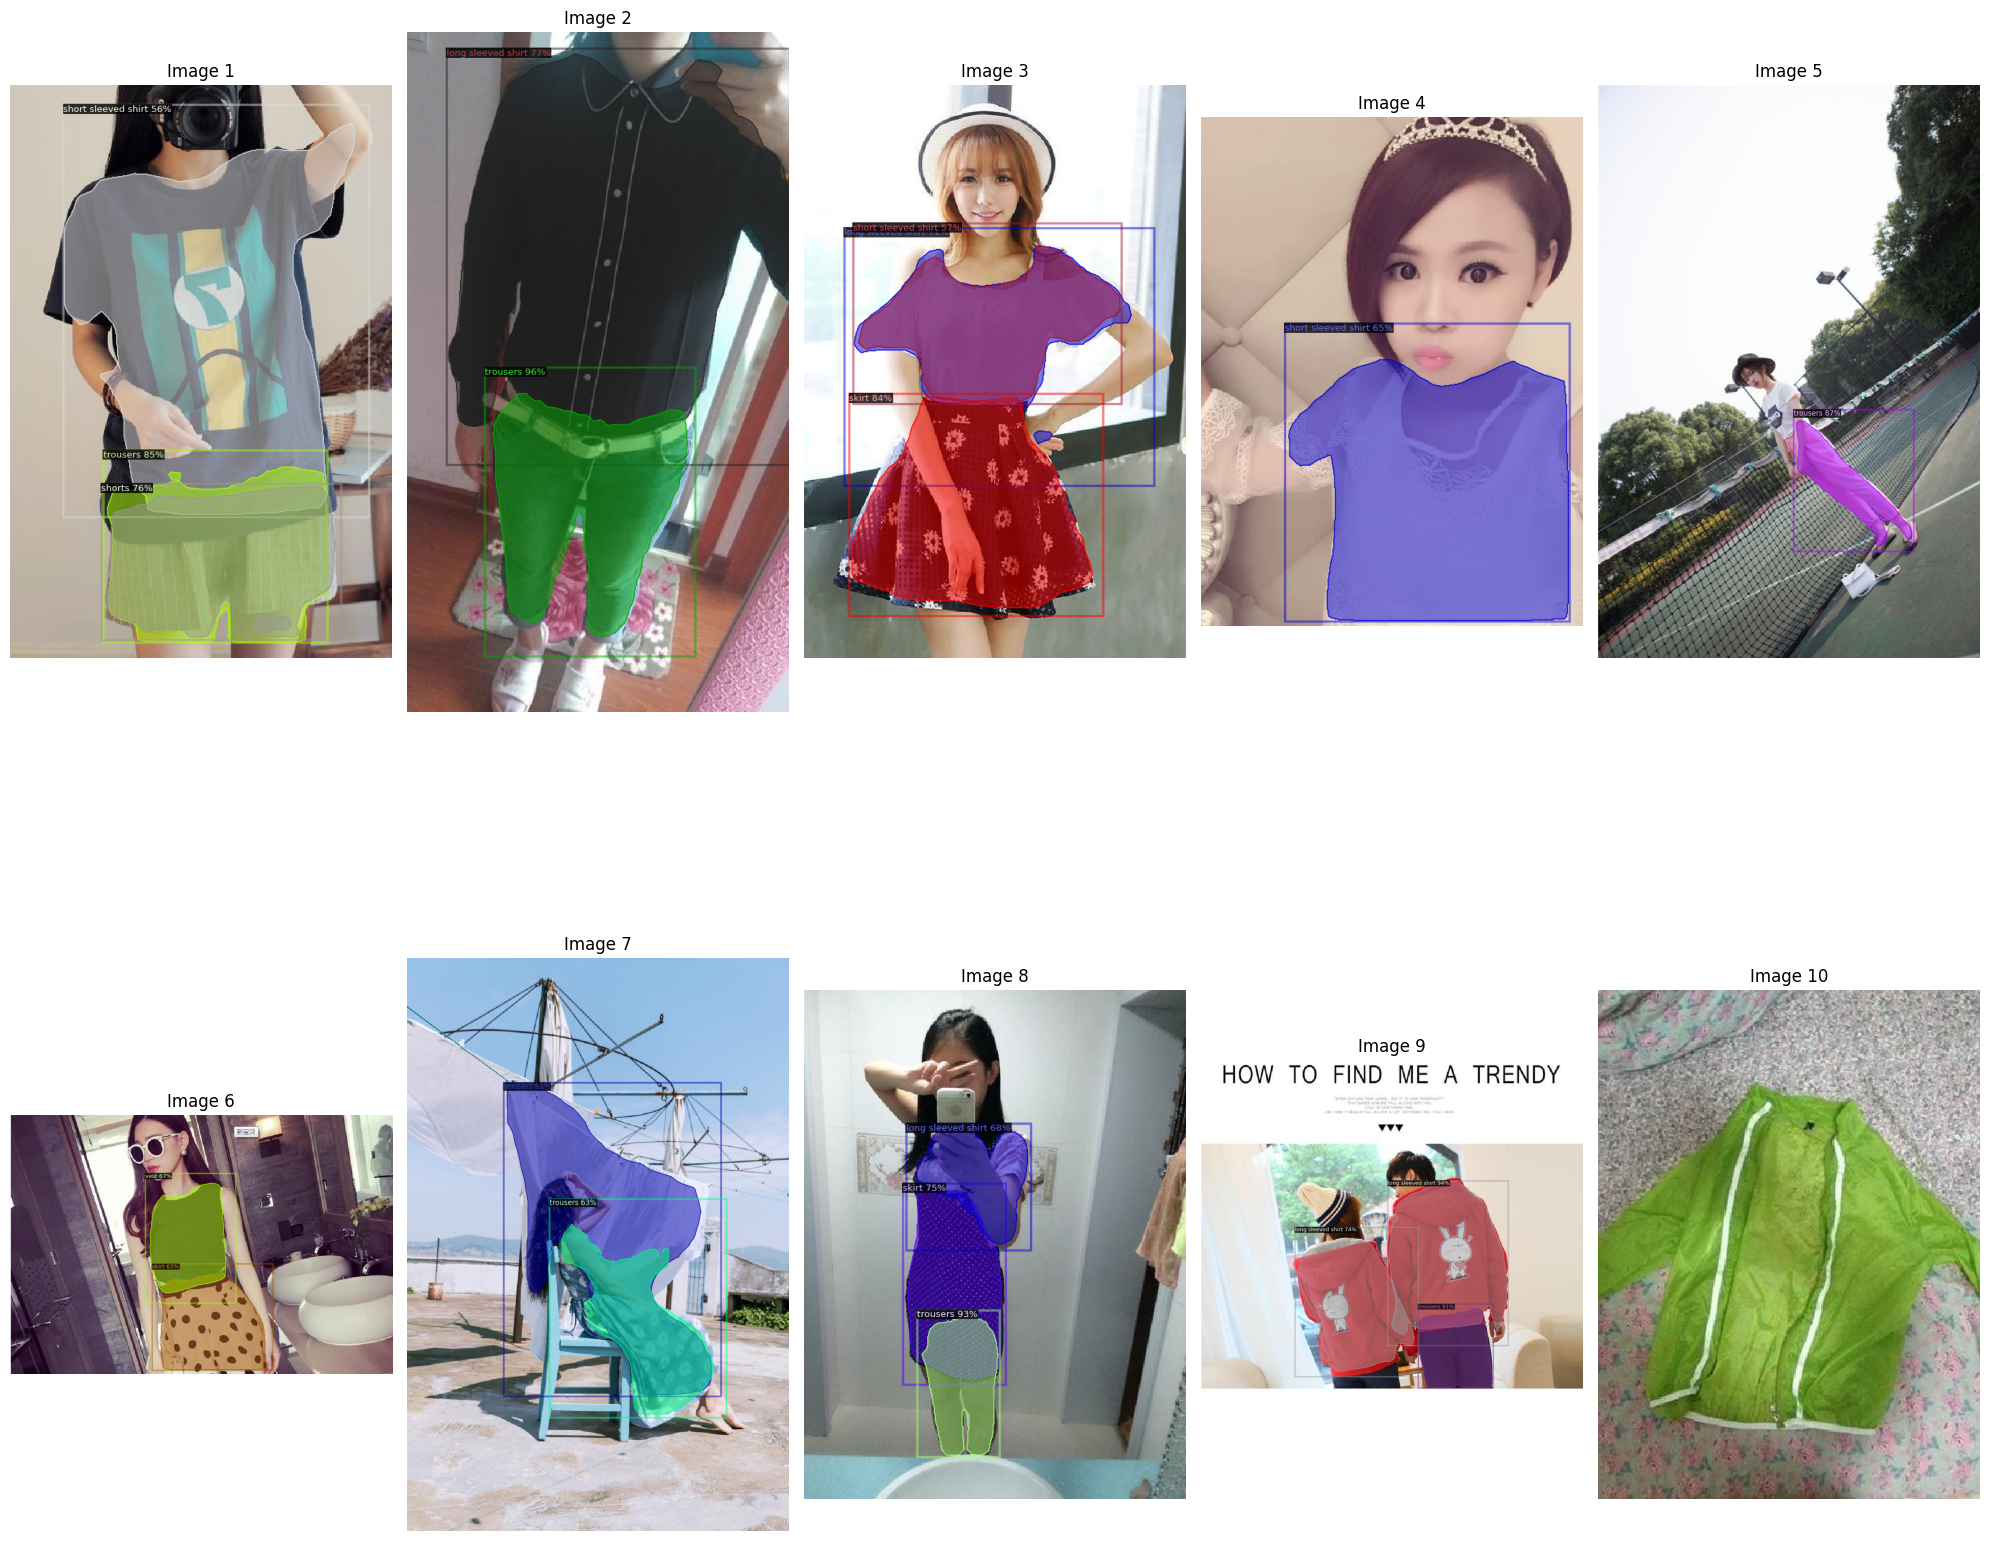

In [15]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

image_dir = "/kaggle/input/df2-train-img/train_image/image"

image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")]

plt.figure(figsize=(20, 20))
for i in range(10):
    # Select a random image
    img_path = random.choice(image_files)
    
    im = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    
    outputs = predictor(im)
    
    v = Visualizer(im, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    plt.subplot(2, 5, i + 1) 
    plt.imshow(v.get_image())
    plt.axis("off")
    plt.title(f"Image {i + 1}")

plt.tight_layout()
plt.show()


In [17]:
from IPython.display import FileLink

FileLink("model_final.pth")

/kaggle/working/model_final.pth